In [55]:
import numpy as np
import pandas as pd
from shutil import copyfile
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
import re
import collections
from astropy.table import Table
from spec_tools import Source_present, Get_Sensitivity,Mag,Scale_model
# from spec_exam import Gen_beam_fits, Gen_DB_and_beams
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from glob import glob
import seaborn as sea
import os
from grizli import model as griz_model

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

In [73]:
def Calzetti(Av,lam):
    lam = lam * 1E-4
    Rv=4.05
    k = 2.659*(-2.156 +1.509/(lam) -0.198/(lam**2) +0.011/(lam**3)) + Rv
    cal = 10**(-0.4*k*Av/Rv)    
    
    return cal

class Gen_spec(object):
    def __init__(self,g102list,g141list, gal_id, g102_min = 8700, g102_max = 11300, g141_min = 11100, g141_max = 16700, sim = True):
        self.gal_id = gal_id
        
        self.g102_list = g102list
        self.g141_list = g141list
        self.g102_wv, self.g102_fl, self.g102_er = self.Stack_1d_beams(self.g102_list,g102_min,g102_max) 
        self.g141_wv, self.g141_fl, self.g141_er = self.Stack_1d_beams(self.g141_list,g141_min,g141_max) 
        
        self.g102_wv = self.g102_wv[self.g102_fl > 0]
        self.g102_er = self.g102_er[self.g102_fl > 0]
        self.g102_fl = self.g102_fl[self.g102_fl > 0]
        
        self.g141_wv = self.g141_wv[self.g141_fl > 0]
        self.g141_er = self.g141_er[self.g141_fl > 0]
        self.g141_fl = self.g141_fl[self.g141_fl > 0]
        
        self.Stack_g102_g141()
        
        if sim == True:
            self.Initialize_sim()
            self.g102_sens = self.Set_sensitivity(self.g102_list[0],self.g102_wv)
            self.g141_sens = self.Set_sensitivity(self.g141_list[0],self.g141_wv)

    def Single_spec(self, beam, min_wv, max_wv):
        BEAM = griz_model.BeamCutout(fits_file= beam)
       
        ivar = BEAM.ivar
        weight = np.exp(-(1*np.abs(BEAM.contam)*np.sqrt(ivar)))
            
        w, f, e = BEAM.beam.optimal_extract(BEAM.grism.data['SCI'], bin=0, ivar=BEAM.ivar)

        flat = BEAM.flat_flam.reshape(BEAM.beam.sh_beam)
        fwave,fflux,ferr = BEAM.beam.optimal_extract(flat, bin=0)
               
        f /= fflux
        e /= fflux

        IDX= [U for U in range(len(w)) if min_wv < w[U] < max_wv]
        
        return w[IDX], f[IDX], e[IDX]
        
    def Set_sensitivity(self,beam,master_wv):    
        BEAM = griz_model.BeamCutout(fits_file= beam)
        
        flat = BEAM.flat_flam.reshape(BEAM.beam.sh_beam)
        fwave,fflux,ferr = BEAM.beam.optimal_extract(flat)

        return interp1d(fwave,fflux)(master_wv)
        
    def Stack_spec(self, stk_wv, flgrid, errgrid):
        #### rearrange flux grid and generate weights
        flgrid = np.transpose(flgrid)
        errgrid = np.transpose(errgrid)
        weigrid = errgrid ** (-2)
        infmask = np.isinf(weigrid) ## remove inif cause by nans in the error grid
        weigrid[infmask] = 0

        #### Stack spectra
        stack_fl, stack_er = np.zeros([2, len(stk_wv)])
        for i in range(len(stk_wv)):
            stack_fl[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
            stack_er[i] = 1 / np.sqrt(np.sum(weigrid[i]))
        
        return stk_wv, stack_fl, stack_er
        
    def Stack_1d_beams(self, beam_list, min_wv, max_wv):
        #### set master wavelength array
        wv,fl,er = self.Single_spec(beam_list[0], min_wv = min_wv, max_wv=max_wv)
        master_wv = wv[1:-1]
        
        #### intialize flux and error grid
        flgrid = np.zeros([len(beam_list), len(master_wv)])
        errgrid = np.zeros([len(beam_list), len(master_wv)])

        #### Get wv,fl,er for each spectra
        for i in range(len(beam_list)):
            wv,fl,er = self.Single_spec(beam_list[i], min_wv = min_wv, max_wv=max_wv)
            flgrid[i] = interp1d(wv, fl)(master_wv)
            errgrid[i] = interp1d(wv, er)(master_wv)
        
        return self.Stack_spec(master_wv, flgrid, errgrid)

    
    def Stack_g102_g141(self): #### good to display, but may not be good for science
        #### make combined wavelength set
        bounds = [min(self.g141_wv),max(self.g102_wv)]
        del_g102 = self.g102_wv[1] - self.g102_wv[0]
        del_g141 = self.g141_wv[1] - self.g141_wv[0]
        del_mix = (del_g102 + del_g141) / 2
        mix_wv = np.arange(bounds[0],bounds[1],del_mix)    
        stack_wv = np.append(np.append(self.g102_wv[self.g102_wv < bounds[0]],mix_wv),self.g141_wv[self.g141_wv > bounds[1]])

        #### intialize flux and error grid
        flgrid = np.zeros([2, len(stack_wv)])
        errgrid = np.zeros([2, len(stack_wv)])

        #### Get wv,fl,er for each spectra
        for i in range(len(stack_wv)):
            if min(self.g102_wv) <= stack_wv[i] <= max(self.g102_wv):
                flgrid[0][i] = interp1d(self.g102_wv, self.g102_fl)(stack_wv[i])
                errgrid[0][i] = interp1d(self.g102_wv, self.g102_er)(stack_wv[i])

            if min(self.g141_wv) <= stack_wv[i] <= max(self.g141_wv):
                flgrid[1][i] = interp1d(self.g141_wv, self.g141_fl)(stack_wv[i])
                errgrid[1][i] = interp1d(self.g141_wv, self.g141_er)(stack_wv[i])

        self.stack_wv, self.stack_fl, self.stack_er = self.Stack_spec(stack_wv, flgrid, errgrid)
        
    def Initialize_sim(self):
        #### pick out orients
        g102_beams = glob('../beams/*{0}*g102*'.format(self.gal_id))
        g102_beamid = [re.findall("o\w[0-9]+",U)[0] for U in g102_beams]
        self.g102_beamid = list(set(g102_beamid))

        g141_beams = glob('../beams/*{0}*g141*'.format(self.gal_id))
        g141_beamid = [re.findall("o\w[0-9]+",U)[0] for U in g141_beams]
        self.g141_beamid = list(set(g141_beamid))
        
        #### initialize dictionary of beams
        self.g102_beam_dict = {}
        self.g141_beam_dict = {}

        #### set beams for each orient
        for i in self.g102_beamid:
            key = i
            value = griz_model.BeamCutout(fits_file= glob('../beams/*{0}*{1}*g102*'.format(i,self.gal_id))[0])
            self.g102_beam_dict[key] = value 
            
        for i in self.g141_beamid:
            key = i
            value = griz_model.BeamCutout(fits_file= glob('../beams/*{0}*{1}*g141*'.format(i,self.gal_id))[0])
            self.g141_beam_dict[key] = value 
        
    def Sim_beam(self,BEAM, mwv, mfl, grism_wv, grism_fl, grism_er, grism_sens):
        ## Compute the models
        BEAM.beam.compute_model(spectrum_1d=[mwv, mfl], is_cgs = True)

        ## Extractions the model (error array here is meaningless)
        w, f, e = BEAM.beam.optimal_extract(BEAM.beam.model, bin=0)

        ## interpolate and scale
        f = interp1d(w,f)(grism_wv) / grism_sens
        C = Scale_model(grism_fl, grism_er,f)

        return C*f
            
    def Gen_sim(self, model_wv, model_fl, redshift,dust=0): 

        cal = 1
        if dust !=0:
            lam = model_wv * 1E-4
            Rv = 4.05
            k = 2.659*(-2.156 +1.509/(lam) -0.198/(lam**2) +0.011/(lam**3)) + Rv
            cal = 10**(-0.4 * k * dust / Rv)  
        
        ### initialize model flux grids
        g102_mfl_grid = np.zeros([len(self.g102_beam_dict.keys()), len(self.g102_wv)])
        g141_mfl_grid = np.zeros([len(self.g141_beam_dict.keys()), len(self.g141_wv)])

        ### simulate each beam
        for i in range(len(self.g102_beamid)):    
            g102_mfl_grid[i] = self.Sim_beam(self.g102_beam_dict[self.g102_beamid[i]], model_wv * (1 + redshift),model_fl * cal, 
                                             self.g102_wv, self.g102_fl, self.g102_er, self.g102_sens)

        for i in range(len(self.g141_beamid)):    
            g141_mfl_grid[i] = self.Sim_beam(self.g141_beam_dict[self.g141_beamid[i]], model_wv * (1 + redshift),model_fl * cal, 
                                             self.g141_wv, self.g141_fl, self.g141_er, self.g141_sens)

        ### stack all sims
        self.g102_mfl = np.mean(g102_mfl_grid,axis=0)
        self.g141_mfl = np.mean(g141_mfl_grid,axis=0)

In [18]:
g102list = glob('../beams/*344*21156*g102*')

In [39]:
g141list = glob('../beams/*188*21156*g141*')

In [74]:
sp = Gen_spec(g102list,g141list,21156,g102_min=8000)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in sqrt
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packa

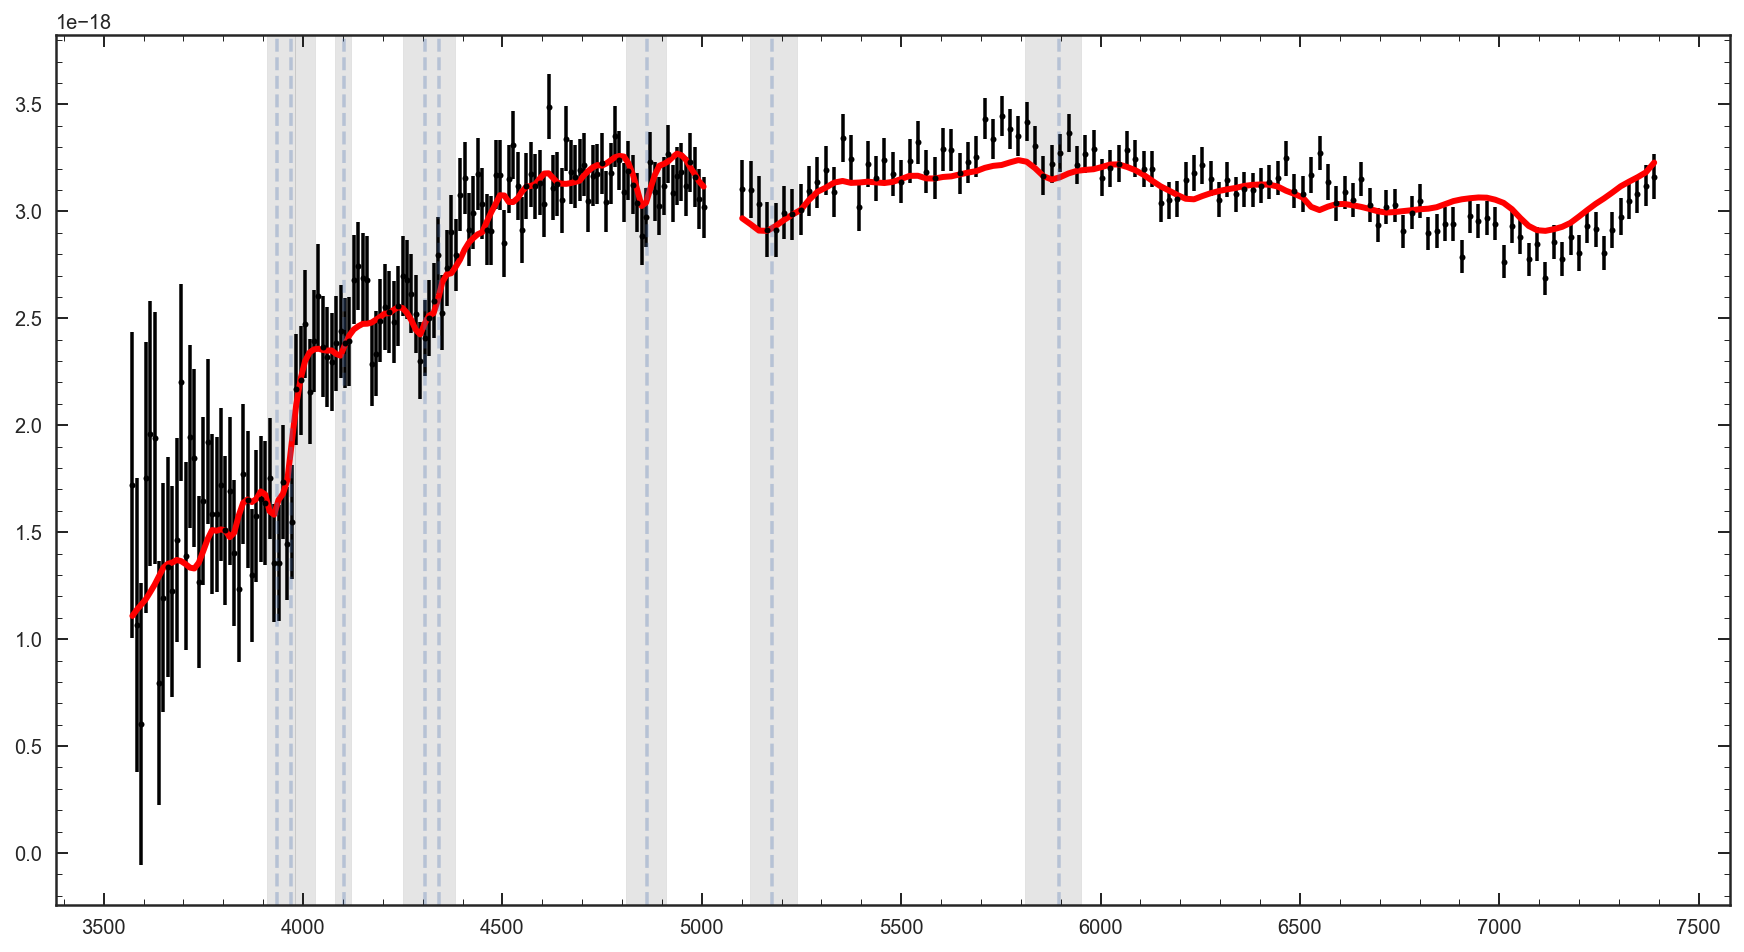

In [76]:
plt.figure(figsize=[15,8])
plt.errorbar(sp.g102_wv/(2.248),sp.g102_fl,sp.g102_er,
             linestyle='None', marker='o', markersize=3,color='k')
plt.errorbar(sp.g141_wv/(2.248),sp.g141_fl,sp.g141_er,
             linestyle='None', marker='o', markersize=3,color='k')
plt.plot(sp.g102_wv/(2.248),sp.g102_mfl,'r',linewidth=3)
plt.plot(sp.g141_wv/(2.248),sp.g141_mfl,'r',linewidth=3)

plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvline(5176.7,linestyle='--', alpha=.3)
plt.axvline(5895.6,linestyle='--', alpha=.3)

plt.axvspan(3910, 3980, color='k', alpha=.1)
plt.axvspan(3980, 4030, color='k', alpha=.1)
plt.axvspan(4080, 4120, color='k', alpha=.1)
plt.axvspan(4250, 4380, color='k', alpha=.1)
plt.axvspan(4810, 4910, color='k', alpha=.1)
plt.axvspan(5120, 5240, color='k', alpha=.1)
plt.axvspan(5810, 5950, color='k', alpha=.1)

In [53]:
wv,fl = np.load('/Users/vestrada/fsps_models_for_fit/fsps_spec/m0.019_a2.0_dt8.0_spec.npy')

In [77]:
from time import time


In [89]:
metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,6.1,.1),1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]

In [92]:
Galaxy_full_analyze(g102list,g141list,metal, age, tau, 1.248, 21156, '21156_test')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in sqrt
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packa

In [91]:
def Scale_model_mult(D, sig, M):
    C = np.sum(((D * M) / sig ** 2), axis=1) / np.sum((M ** 2 / sig ** 2), axis=1)
    return C

def Galaxy_full_fit(g102beams,g141beams,metal, age, tau, specz, galaxy, name):
    #############Read in spectra#################
    spec = Gen_spec(g102beams,g141beams,galaxy,g102_min=8000)

    ##############Create g102 chigrid and add to file#################
    g102mfl = np.zeros([len(metal)*len(age)*len(tau),len(spec.g102_wv)])
    g141mfl = np.zeros([len(metal)*len(age)*len(tau),len(spec.g141_wv)])

    for i in range(len(metal)):
        for ii in range(len(age)):
            for iii in range(len(tau)):
                wv,fl = np.load('/Users/vestrada/fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(
                    metal[i], age[ii], tau[iii]))
                spec.Gen_sim(wv,fl,specz)
                g102mfl[i*len(age)*len(tau) + ii*len(tau) + iii] = spec.g102_mfl
                g141mfl[i*len(age)*len(tau) + ii*len(tau) + iii] = spec.g141_mfl
                    
    np.save('../spec_files/g102_{0}'.format(name),g102mfl)
    np.save('../spec_files/g141_{0}'.format(name),g141mfl)
    
    Galaxy_full_analyze(g102beams,g141beams,metal, age, tau, specz, galaxy, name)
    
def Galaxy_full_analyze(g102beams,g141beams,metal, age, tau, specz, galaxy, name):
    Redden(g102beams,g141beams,galaxy,name,metal,specz)
    g102grids = ['../chidat/g102_{0}_d{1}_chidata.npy'.format(name,U) for U in range(11)]
    g141grids = ['../chidat/g141_{0}_d{1}_chidata.npy'.format(name,U) for U in range(11)]
    combgrids = ['../chidat/comb_{0}_d{1}_chidata.npy'.format(name,U) for U in range(11)]
    
    P, PZ, Pt, Ptau, Pd = Analyze_full_fit(g102grids, metal, age, tau)

    np.save('../chidat/g102_%s_tZ_pos' % name,P)
    np.save('../chidat/g102_%s_Z_pos' % name,[metal,PZ])
    np.save('../chidat/g102_%s_t_pos' % name,[age,Pt])
    np.save('../chidat/g102_%s_tau_pos' % name,[np.append(0, np.power(10, np.array(tau)[1:] - 9)),Ptau])
    np.save('../chidat/g102_%s_d_pos' % name,[np.arange(0,1.1,0.1),Pd])
    
    P, PZ, Pt, Ptau, Pd = Analyze_full_fit(g141grids, metal, age, tau)

    np.save('../chidat/g141_%s_tZ_pos' % name,P)
    np.save('../chidat/g141_%s_Z_pos' % name,[metal,PZ])
    np.save('../chidat/g141_%s_t_pos' % name,[age,Pt])
    np.save('../chidat/g141_%s_tau_pos' % name,[np.append(0, np.power(10, np.array(tau)[1:] - 9)),Ptau])
    np.save('../chidat/g141_%s_d_pos' % name,[np.arange(0,1.1,0.1),Pd])
    
    P, PZ, Pt, Ptau, Pd = Analyze_full_fit(combgrids, metal, age, tau)

    np.save('../chidat/comb_%s_tZ_pos' % name,P)
    np.save('../chidat/comb_%s_Z_pos' % name,[metal,PZ])
    np.save('../chidat/comb_%s_t_pos' % name,[age,Pt])
    np.save('../chidat/comb_%s_tau_pos' % name,[np.append(0, np.power(10, np.array(tau)[1:] - 9)),Ptau])
    np.save('../chidat/comb_%s_d_pos' % name,[np.arange(0,1.1,0.1),Pd])
    
def Redden(g102beams,g141beams,galaxy,name,metal,specz):
    #############Read in spectra#################
    spec = Gen_spec(g102beams,g141beams,galaxy,g102_min=8000)

    g102mfl = np.load('../spec_files/g102_{0}.npy'.format(name))
    g141mfl = np.load('../spec_files/g141_{0}.npy'.format(name))
    
    Av = np.arange(0, 1.1, 0.1)
    for i in range(len(Av)):
        g102dust = Calzetti(Av[i],spec.g102_wv / (1+specz))
        g141dust = Calzetti(Av[i],spec.g141_wv / (1+specz))
        
        g102redflgrid = g102mfl * g102dust
        g141redflgrid = g141mfl * g141dust
        
        g102SCL = Scale_model_mult(spec.g102_fl,spec.g102_er,g102redflgrid)
        g141SCL = Scale_model_mult(spec.g141_fl,spec.g141_er,g141redflgrid)
        
        g102redflgrid = np.array([g102SCL]).T*g102redflgrid
        g141redflgrid = np.array([g141SCL]).T*g141redflgrid
        
        g102chigrid = np.sum(((spec.g102_fl - g102redflgrid) / spec.g102_er) ** 2, axis=1).reshape([len(metal), len(age), len(tau)])
        np.save('../chidat/g102_{0}_d{1}_chidata'.format(name, i),g102chigrid)
        
        g141chigrid = np.sum(((spec.g141_fl - g141redflgrid) / spec.g141_er) ** 2, axis=1).reshape([len(metal), len(age), len(tau)])
        np.save('../chidat/g141_{0}_d{1}_chidata'.format(name, i),g141chigrid)
        
        combgrid = g102chigrid + g141chigrid
        np.save('../chidat/comb_{0}_d{1}_chidata'.format(name, i),combgrid)

        
        
def Stich_grids(grids):
    stc = []
    for i in range(len(grids)):
        stc.append(np.load(grids[i]))
    return np.array(stc)

def Analyze_full_fit(chifiles, metal, age, tau, dust = np.arange(0,1.1,0.1), age_conv='/Users/vestrada/Github/Quiescent_analysis/data/light_weight_scaling_3.npy'):
    ####### Get maximum age
    max_age = 4.98
    
    ####### Read in file   
    chi = Stich_grids(chifiles)
    
    chi[ : , : , len(age[age <= max_age]):] = 1E5

    ####### Get scaling factor for tau reshaping
    ultau = np.append(0, np.power(10, np.array(tau)[1:] - 9))
    
    convtable = np.load(age_conv)

    overhead = np.zeros([len(tau),metal.size]).astype(int)
    for i in range(len(tau)):
        for ii in range(metal.size):
            amt=[]
            for iii in range(age.size):
                if age[iii] > convtable.T[i].T[ii][-1]:
                    amt.append(1)
            overhead[i][ii] = sum(amt)

    ######## get Pd and Pz
    P_full = np.exp(- chi / 2).astype(np.float128)
    Pd = np.trapz(np.trapz(np.trapz(P_full,ultau, axis=3), age, axis=2), metal, axis=1) /\
                  np.trapz(np.trapz(np.trapz(np.trapz(P_full, ultau, axis=3), age, axis=2), metal, axis=1),dust)

    P = np.trapz(P_full.T, dust, axis=3).T
    new_P = np.zeros(P.T.shape)

    ######## Reshape likelihood to get light weighted age instead of age when marginalized
    for i in range(len(tau)):
        frame = np.zeros([metal.size,age.size])
        for ii in range(metal.size):
            dist = interp1d(convtable.T[i].T[ii],P.T[i].T[ii])(age[:-overhead[i][ii]])
            frame[ii] = np.append(dist,np.repeat(0, overhead[i][ii]))
        new_P[i] = frame.T

    ####### Create normalize probablity marginalized over tau
    P = new_P.T

    # test_prob = np.trapz(test_P, ultau, axis=2)
    C = np.trapz(np.trapz(np.trapz(P, ultau, axis=2), age, axis=1), metal)

    P /= C

    prob = np.trapz(P, ultau, axis=2)
    
    # #### Get Z, t, tau, and z posteriors
    PZ = np.trapz(np.trapz(P, ultau, axis=2), age, axis=1)
    Pt = np.trapz(np.trapz(P, ultau, axis=2).T, metal, axis=1)
    Ptau = np.trapz(np.trapz(P.T, metal, axis=2), age, axis=1)

    return prob.T, PZ, Pt, Ptau, Pd

In [99]:
def Median_w_Error_cont(Pofx, x):
    ix = np.linspace(x[0], x[-1], 5000)
    iP = interp1d(x, Pofx)(ix)

    C = np.trapz(iP,ix)

    iP/=C


    lerr = 0
    herr = 0
    med = 0

    for i in range(len(ix)):
        e = np.trapz(iP[0:i + 1], ix[0:i + 1])
        if lerr == 0:
            if e >= .16:
                lerr = ix[i]
        if med == 0:
            if e >= .50:
                med = ix[i]
        if herr == 0:
            if e >= .84:
                herr = ix[i]
                break

    return med, med - lerr, herr - np.abs(med)


In [111]:
print((0.008928185637127424 + 0.006754950990198037) / 0.019)
print((0.0028453690738147602 + 0.004195239047809558) / 0.019)
print((0.003937587517503498 + 0.004514502900580121) / 0.019)

0.8254282435434455
0.37055832219075363
0.4448468641096642


(0.019363472694538905, 0.008928185637127424, 0.006754950990198037)
(0.02103260652130426, 0.0028453690738147602, 0.004195239047809558)
(0.021855971194238842, 0.003937587517503498, 0.004514502900580121)


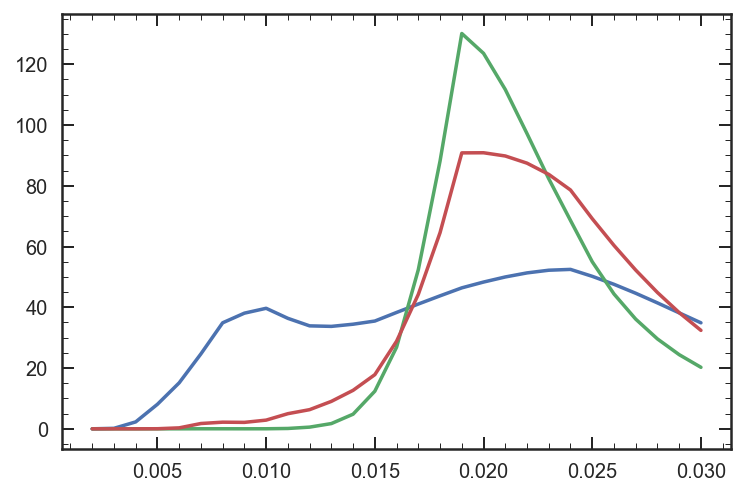

In [101]:
Z102, PZ102 = np.load('../chidat/g102_21156_test_Z_pos.npy')
Z141, PZ141 = np.load('../chidat/g141_21156_test_Z_pos.npy')
Zcom, PZcom = np.load('../chidat/comb_21156_test_Z_pos.npy')

print(Median_w_Error_cont(PZ102,metal))
print(Median_w_Error_cont(PZ141,metal))
print(Median_w_Error_cont(PZcom,metal))

plt.plot(Z102,PZ102)
plt.plot(Z141,PZ141)
plt.plot(Zcom,PZcom)

In [110]:
print(0.5347069413882779 + 0.7976595319063811)
print(0.5688137627525505 + 0.5248049609921983)
print(0.35537107421484304 + 0.22114422884576923)

1.332366473294659
1.0936187237447488
0.5765153030606123


(2.349469893978796, 0.5347069413882779, 0.7976595319063811)
(3.785257051410282, 0.5688137627525505, 0.5248049609921983)
(2.797259451890378, 0.35537107421484304, 0.22114422884576923)


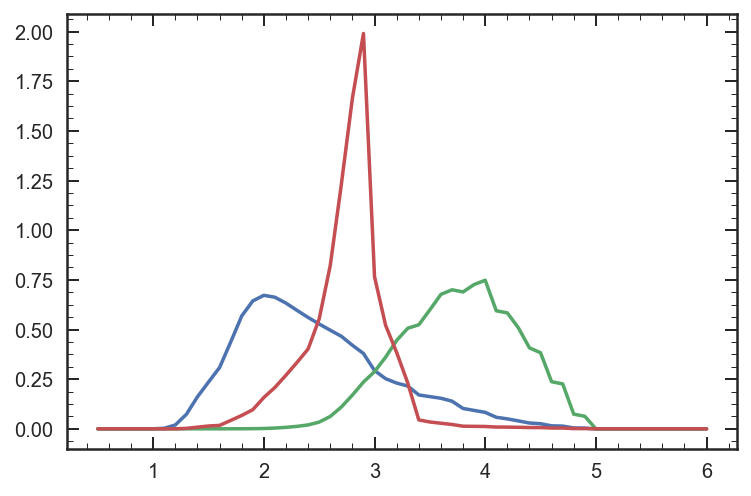

In [102]:
Z102, PZ102 = np.load('../chidat/g102_21156_test_t_pos.npy')
Z141, PZ141 = np.load('../chidat/g141_21156_test_t_pos.npy')
Zcom, PZcom = np.load('../chidat/comb_21156_test_t_pos.npy')

print(Median_w_Error_cont(PZ102,age))
print(Median_w_Error_cont(PZ141,age))
print(Median_w_Error_cont(PZcom,age))

plt.plot(Z102,PZ102)
plt.plot(Z141,PZ141)
plt.plot(Zcom,PZcom)

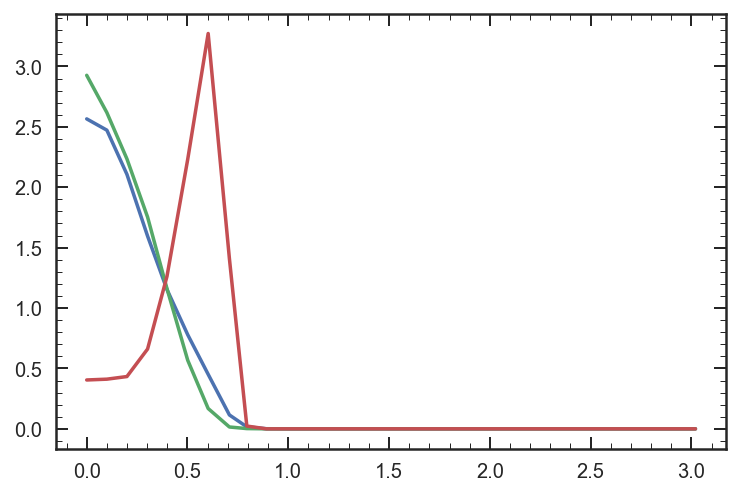

In [105]:
Z102, PZ102 = np.load('../chidat/g102_21156_test_tau_pos.npy')
Z141, PZ141 = np.load('../chidat/g141_21156_test_tau_pos.npy')
Zcom, PZcom = np.load('../chidat/comb_21156_test_tau_pos.npy')

plt.plot(Z102,PZ102)
plt.plot(Z141,PZ141)
plt.plot(Zcom,PZcom)

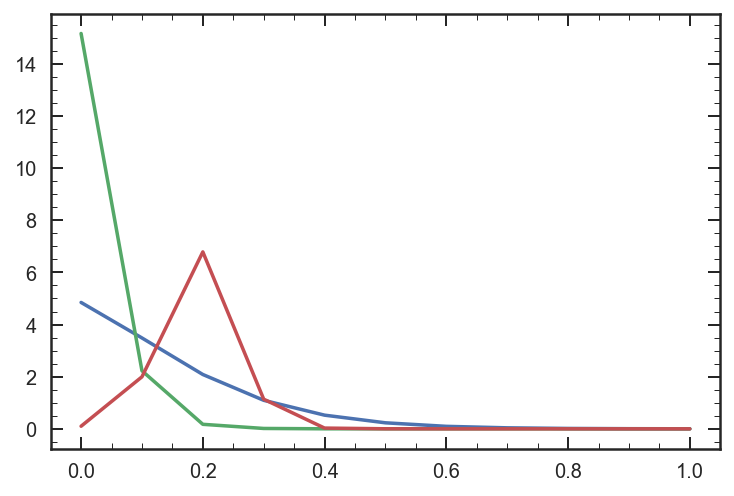

In [98]:
Z102, PZ102 = np.load('../chidat/g102_21156_test_d_pos.npy')
Z141, PZ141 = np.load('../chidat/g141_21156_test_d_pos.npy')
Zcom, PZcom = np.load('../chidat/comb_21156_test_d_pos.npy')

plt.plot(Z102,PZ102)
plt.plot(Z141,PZ141)
plt.plot(Zcom,PZcom)

In [106]:
wv,fl = np.load('/Users/vestrada/fsps_models_for_fit/fsps_spec/m0.021_a2.8_dt0_spec.npy')
sp.Gen_sim(wv,fl,1.248,dust=0.2)

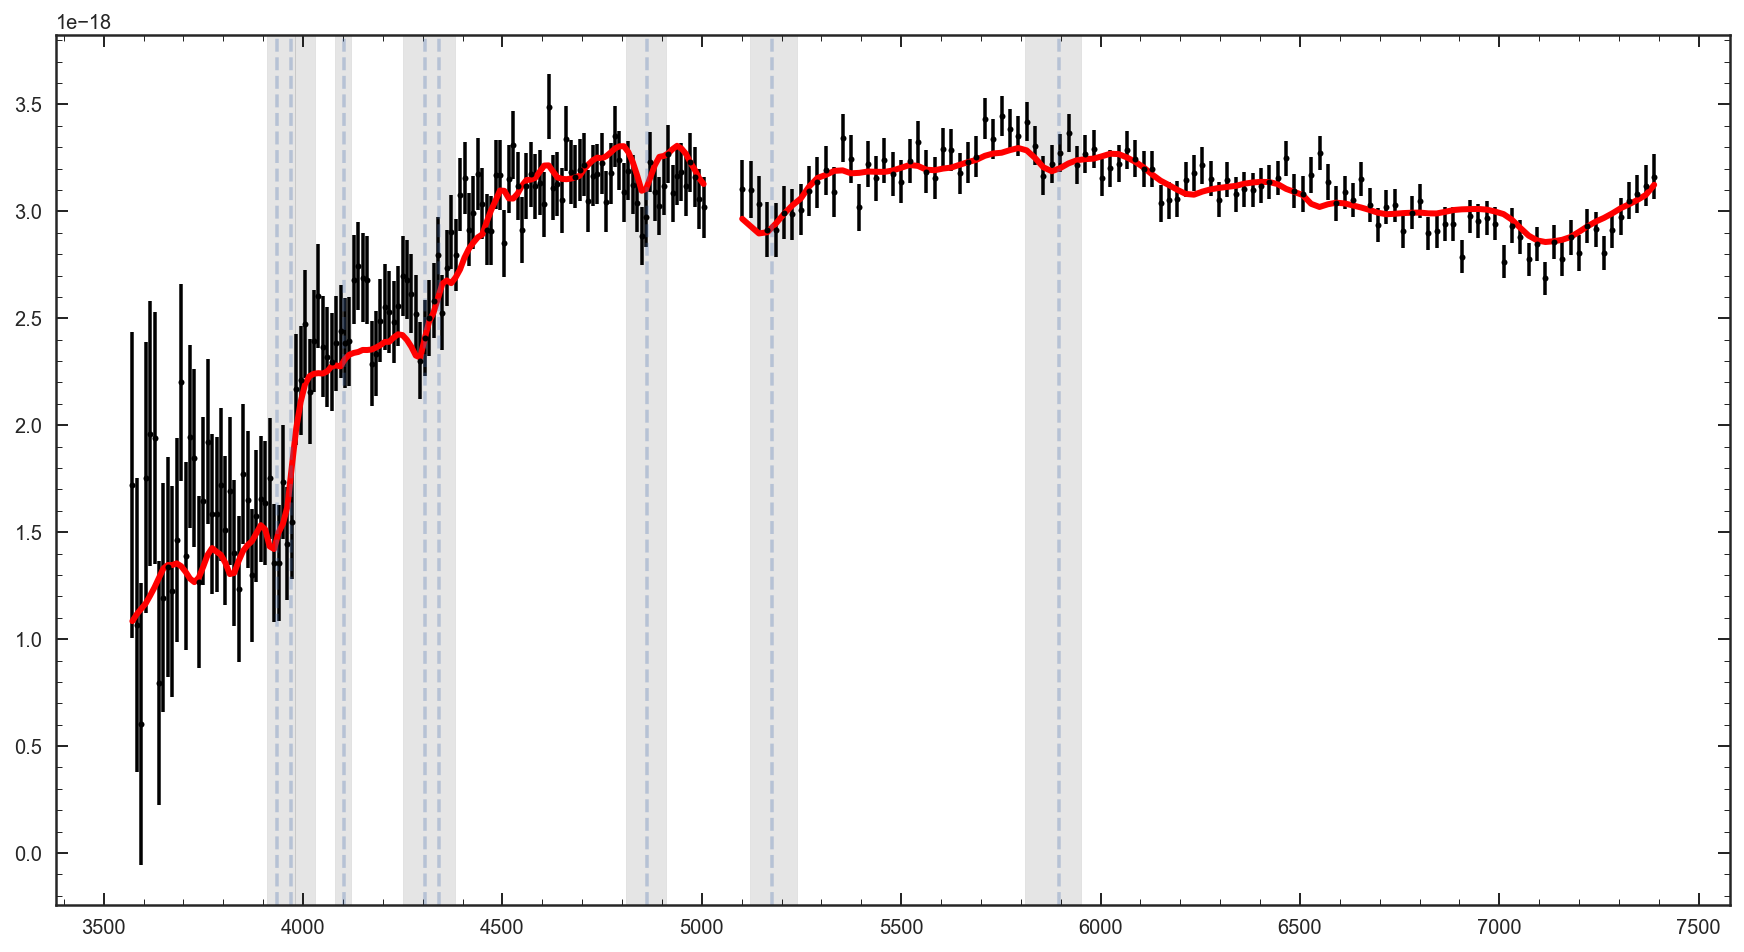

In [107]:
plt.figure(figsize=[15,8])
plt.errorbar(sp.g102_wv/(2.248),sp.g102_fl,sp.g102_er,
             linestyle='None', marker='o', markersize=3,color='k')
plt.errorbar(sp.g141_wv/(2.248),sp.g141_fl,sp.g141_er,
             linestyle='None', marker='o', markersize=3,color='k')
plt.plot(sp.g102_wv/(2.248),sp.g102_mfl,'r',linewidth=3)
plt.plot(sp.g141_wv/(2.248),sp.g141_mfl,'r',linewidth=3)

plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvline(5176.7,linestyle='--', alpha=.3)
plt.axvline(5895.6,linestyle='--', alpha=.3)

plt.axvspan(3910, 3980, color='k', alpha=.1)
plt.axvspan(3980, 4030, color='k', alpha=.1)
plt.axvspan(4080, 4120, color='k', alpha=.1)
plt.axvspan(4250, 4380, color='k', alpha=.1)
plt.axvspan(4810, 4910, color='k', alpha=.1)
plt.axvspan(5120, 5240, color='k', alpha=.1)
plt.axvspan(5810, 5950, color='k', alpha=.1)